In [1]:
import os
import cv2
import zipfile
from tqdm import tqdm
from io import BytesIO
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

In [2]:
from google.colab import files
uploaded = files.upload()

Saving CK+48.zip to CK+48.zip


In [3]:

zip_path = next(iter(uploaded))
with zipfile.ZipFile(BytesIO(uploaded[zip_path]), 'r') as zip_ref:
    zip_ref.extractall("/content/CK+48")
extracted_path = "/content/CK+48/CK+48"
os.listdir(extracted_path)
DATADIR = extracted_path
CATEGORIES = os.listdir(DATADIR)

In [4]:
def load_data():
    data = []

    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])

    return data

In [5]:

data = load_data()
len(data)


100%|██████████| 84/84 [00:00<00:00, 6942.98it/s]


981

In [6]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))
X_train_Gabor  = X_train
X_test_Gabor = X_test
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train_SVM = y_train
y_test_SVM = y_test
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values
            img1_vector = np.delete(img1_vector,4)
            digit = np.where(img1_vector)[0]
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

(-0.5, 47.5, 47.5, -0.5)

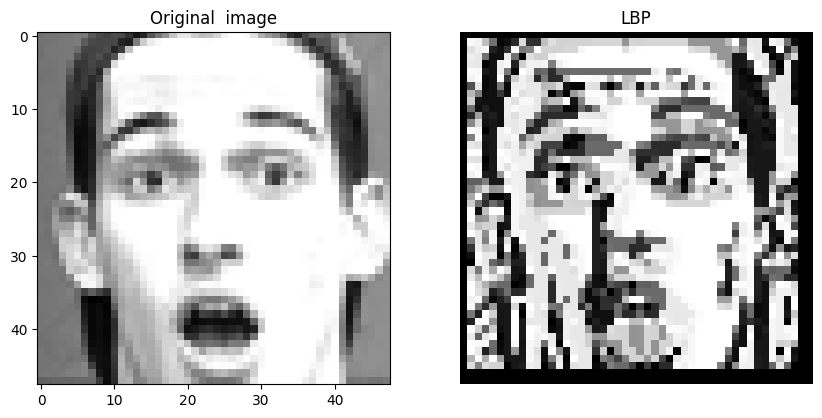

In [8]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
img = random.choice(X_train)
plt.title("Original  image")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img)             # calling the LBP function using gray image
plt.imshow(imgLBP, cmap='gray')
plt.axis('off')

CREATING FEATURE VECTORS FOR TRAINING AND TESTING

In [9]:
X_train.shape

(784, 48, 48, 1)

In [10]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)
        Feature_data[i] = imgLBP

    return Feature_data

In [11]:
Feature_X_train = create_LBP_features(X_train)

In [12]:
Feature_X_train.shape

(784, 48, 48, 1)

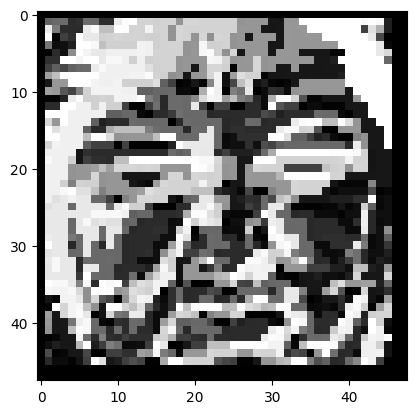

In [13]:
img = random.choice(Feature_X_train)
plt.imshow(img, cmap='gray')

In [14]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(197, 48, 48, 1)

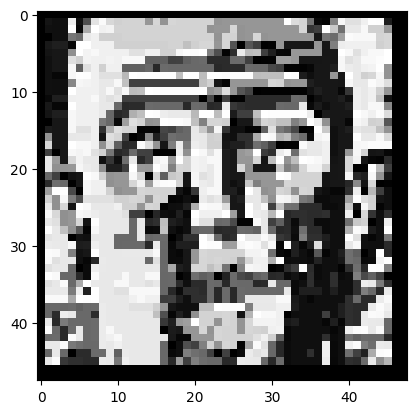

In [15]:
img = random.choice(Feature_X_test)
plt.imshow(img, cmap='gray')

Training and testing LBP-CNN model

In [16]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    return model

es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [17]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [18]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=50, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 6s 46ms/step - loss: 7.4217 - accuracy: 0.2679 - val_loss: 1.6745 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 5s 46ms/step - loss: 1.4896 - accuracy: 0.4668 - val_loss: 1.3311 - val_accuracy: 0.5584 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 5s 52ms/step - loss: 1.1256 - accuracy: 0.6020 - val_loss: 0.9070 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 4s 42ms/step - loss: 0.8705 - accuracy: 0.6977 - val_loss: 0.7413 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 4s 45ms/step - loss: 0.6383 - accuracy: 0.7870 - val_loss: 0.5447 - val_accuracy: 0.8173 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 4s 44ms/step - loss: 0.4346 - accuracy: 0.8597 - val_loss: 0.4769 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 5s 47ms/step - loss: 0.3

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np


In [20]:

y_pred = np.argmax(LBP_model.predict(Feature_X_test), axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# Print classification report
classification_rep = classification_report(y_test_labels, y_pred)
print("Classification Report:\n", classification_rep)

7/7 [==============================] - 0s 19ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.94      0.97        16
           2       0.89      0.94      0.91        33
           3       1.00      0.92      0.96        38
           4       1.00      1.00      1.00        12
           5       0.96      0.96      0.96        51
           6       0.93      1.00      0.96        13

    accuracy                           0.96       197
   macro avg       0.96      0.97      0.96       197
weighted avg       0.96      0.96      0.96       197



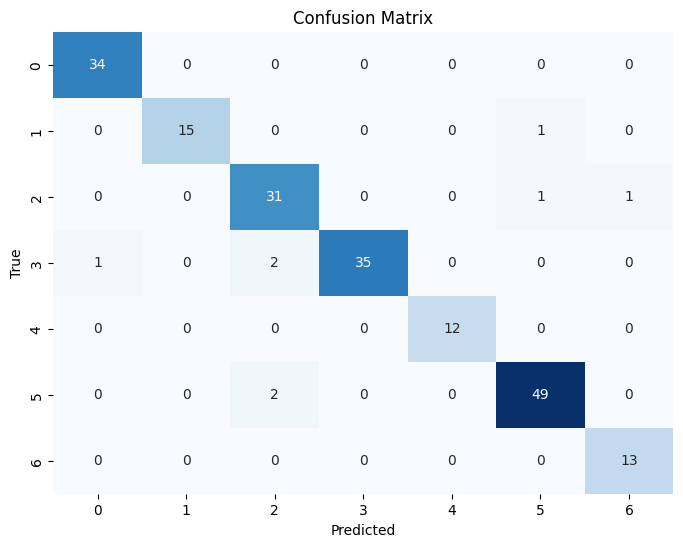

In [21]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test_labels), yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

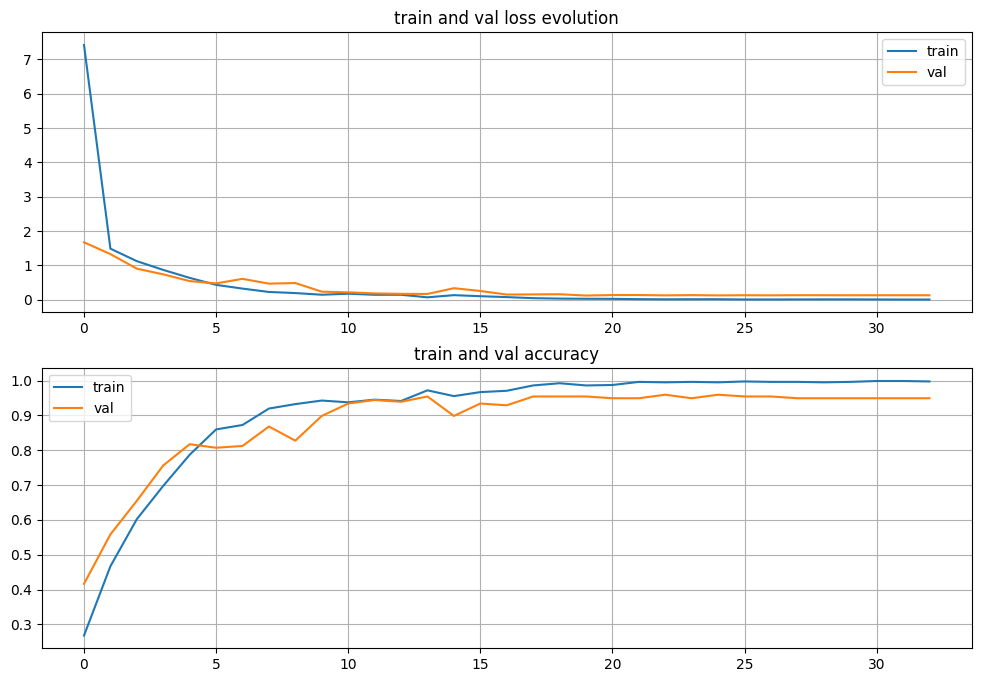

In [23]:
plot_performance(LBP_history)

In [24]:

print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.9593908786773682


In [25]:
LBP_model.save('LBP_model.keras')